Данные, которые я хочу сейчас проанализировать вместе с вами, взяты из статьи 2009 года. В ней собраны оценки почти 6500 португальских вин Vinho Verde, выставленных дегустаторами при слепом тестировании в баллах по шкале от 0 до 10.

In [1]:
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


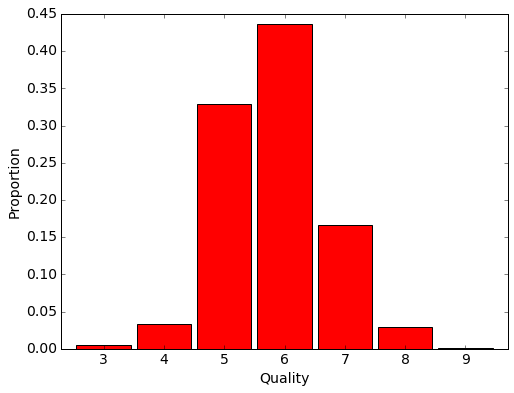

In [6]:
#прочитаем данные
wine = pd.read_csv('wine_data.csv', sep='\t', header=0)
wine=wine.sample(frac=1)

#так выглядит распределение экспертных оценок
plt.figure(figsize(8,6))
stat=wine.groupby('quality')['quality'].agg(lambda x:float(len(x))/wine.shape[0])
stat.plot(kind='bar', fontsize=14, width=0.9, color="red")
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

Вот так выглядит распределение экспертных оценок в нашей выборке. Как вы видите, большая часть вин получает оценку в 6 баллов. Есть несколько вин, получающих 9 баллов, и немного вин — 3 балла. 

Давайте научимся предсказывать этот признак, чтобы мы могли заранее предположить, какую оценку получит вино, которого нет в нашей выборке. 

In [29]:
# Чтобы полноценно смоделировать эту ситуацию, давайте 
# отделим 25 % данных и оставим их для контроля 
# качества предсказания, а обучаться будем на 
# оставшихся 75 %.
X_train, X_test, Y_train, Y_test = train_test_split(wine.ix[:, wine.columns!='quality'], wine['quality'], test_size=0.25, 
                  stratify=wine[['Type', 'quality']])

X_train['Type']=X_train['Type'].apply(lambda x:-1 if x=="red" else 1)
X_test['Type']=X_test['Type'].apply(lambda x:-1 if x=="red" else 1)


Если у нас больше нет никакой информации, то наше лучшее предположение об оценке — это среднее всех имеющихся в обучающей выборке, то есть в данном случае 5,8 балла. 

In [30]:
np.mean(Y_train)

5.823994252873563

Если мы этой величиной будем предсказывать оценку всех вин, то на обучающей выборке мы получим среднеквадратичную ошибку 0,87 баллов, а на тестовой — 0,88. На тестовой выборке ошибка больше, поскольку среднее мы оценивали по обучающей. Это естественный эффект. 

In [31]:
err_train = sqrt(mean_squared_error([np.mean(Y_train)]*len(Y_train), Y_train))
err_test = sqrt(mean_squared_error([np.mean(Y_train)]*len(Y_test), Y_test))

print("Error train:%s" % err_train)
print("Error test:%s" % err_test)

Error train:0.874700872145
Error test:0.86870923896


# Тип вина

 На самом деле у нас есть еще какая-то информация, например о типе вина. В нашей выборке примерно 1600 красных вин и 4900 белых. Причем, если мы посмотрим на экспертные оценки отдельно по этим категориям, мы увидим, что они существенно отличаются.

In [26]:
wine.groupby('Type')['Type'].count()

Type
red      1599
white    4898
Name: Type, dtype: int64

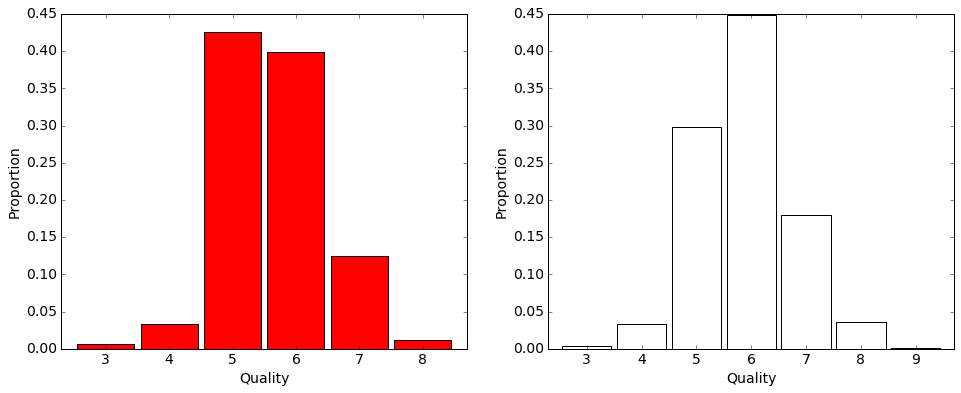

In [34]:
plt.figure(figsize(16,6))
plt.subplot(121)
stat_red=wine[wine['Type']=="red"].groupby('quality')['quality'].agg(lambda x:float(len(x))/wine[wine['Type'] == 'red'].shape[0])
stat_red.plot(kind='bar', fontsize=14, width=0.9, color="red")
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

plt.subplot(122)
stat_white=wine[wine['Type']=="white"].groupby('quality')['quality'].agg(lambda x:float(len(x))/wine[wine['Type'] == 'white'].shape[0])
stat_white.plot(kind='bar', fontsize=14, width=0.9, color="w")
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

 Так, большая часть белых вин получает оценку в 6 баллов, а большая часть красных — в 5. Нет ни одного красного вина, которое получает оценку 9 баллов. Различие между средними оценками по типам вина статистически значимо, критерий Стьюдента это подтверждает. 

In [36]:
import statsmodels.stats.api as sm

tmeans = sm.CompareMeans(sm.DescrStatsW(wine[wine['Type'] == 'white']['quality']), 
                         sm.DescrStatsW(wine[wine['Type'] == 'red']['quality']))

tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]
##95% доверительный интервал для разности средних оценок:

4.8880690442018232e-22

In [37]:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.19293009404017963, 0.29084357932805199)

Чтобы уточнить наши предсказания, мы можем оценку каждого вина предсказывать средним по оценкам вин такого же типа в нашей обучающей выборке.

In [41]:
regressor = LinearRegression()
regressor.fit(X_train['Type'].reshape(-1,1), Y_train)

y_train_predictions = regressor.predict(X_train['Type'].reshape(-1,1))
y_test_predictions = regressor.predict(X_test['Type'].reshape(-1,1))


 Если мы будем так делать, ошибки предсказания немного уменьшатся, а ошибка на обучающей выборке будет составлять 0,86, а на тестовой — 0,88. 

In [42]:
err_train=sqrt(mean_squared_error(y_train_predictions, Y_train))
err_test=sqrt(mean_squared_error(y_test_predictions, Y_test))

print("Error train:%s" % err_train)
print("Error test:%s" % err_test)

Error train:0.868333136276
Error test:0.862863542107


Вот так выглядят истинные оценки вин и их предсказания средними по типам на тестовой выборке

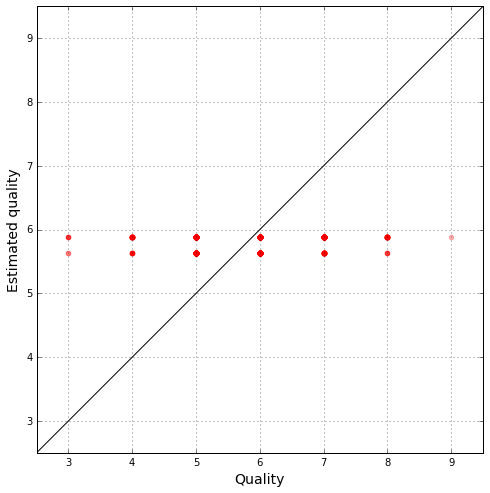

In [44]:
pyplot.figure(figsize(8,8))
pyplot.scatter(Y_test, y_test_predictions, color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)

# Другие признаки

In [49]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3)
rf.fit(X_train, Y_train)

importances = pd.DataFrame(zip(X_train.columns, rf.feature_importances_))
importances.columns = ['feature name', 'importance']
importances.sort_values(by='importance', ascending=False)

,feature name,importance
11,Alcohol (%),0.275063
2,Volatile acidity (g/l),0.129731
6,Free sulfur dioxide (mg/l),0.089060
10,Sulphates (g/l),0.076856
7,Total sulfur dioxide (mg/l),0.071936
4,Residual sugar (g/l),0.067945
5,Chlorides (g/l),0.063383
9,pH,0.062649
3,Citric acid (g/l),0.057689
8,Density (g/cm3),0.056984


Cильнее всего на экспертную оценку качества вина влияет содержание алкоголя